### GCN implementation for Fake News Detection on UPFD dataset

# Setup


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import the pytorch library into environment and check its version
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


In [5]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

import torch_geometric
torch_geometric.__version__

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


'2.4.0'

In [36]:
import argparse
import os.path as osp
import numpy as np
from math import ceil
import pandas as pd
import copy
from tqdm import tqdm, trange

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, DenseSAGEConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch_geometric.nn import global_mean_pool as gmp

import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch_geometric.nn import global_mean_pool

# GCN
## Load Data

In [7]:
def load_data(split):
  """
  Load train, validation, and test data from the UPFD dataset in PyG. Concact node
  features *profile* and *bert*, which are Twitter user's profile attributes and
  historical tweets encoded through BERT respectively.

  -------------------------------------
  split: 'train', 'val', or 'test' for retrieving the respective portion of UPFD.

  -------------------------------------
  Return: PyG dataset object.
  """

  data_profile =  UPFD('/tmp/test', "politifact", "profile", split, ToUndirected())
  data_bert =  UPFD('/tmp/test', "politifact", "bert", split, ToUndirected())
  data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)

  return data_profile

In [8]:
# Retrieve data
train_data = load_data('train')
test_data = load_data('test')
val_data = load_data('val')

# Prepare data loader for GNN
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Extracting /tmp/test/politifact/raw/uc
Processing...
Done!
Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [9]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}, number of graphs in the current batch: {data.num_graphs}')
    print(f'Step {step + 1}, number of nodes in the current batch: {data.num_nodes}')
    print(f'Step {step + 1}, the graph id to which each node belongs is: {data.batch}')
    print()

Step 1, number of graphs in the current batch: 62
Step 1, number of nodes in the current batch: 6072
Step 1, the graph id to which each node belongs is: tensor([ 0,  0,  0,  ..., 61, 61, 61])



In [47]:
data.x.shape

torch.Size([72, 778])

## GCN Architecture

In [48]:


class GCN(torch.nn.Module):
  def __init__(self, args):
    super(GCN, self).__init__()

    self.GCNConv1 = GCNConv(args.num_features, args.hidden_dim) #first GCNConv module
    self.batchnorm = torch.nn.BatchNorm1d(args.hidden_dim)
    self.GCNConv2 = GCNConv(args.hidden_dim, args.hidden_dim) #second GCNConv module
    self.Linear = torch.nn.Linear(args.hidden_dim, args.num_classes) #linear function
    self.relu = torch.nn.ReLU() #relu function

  def forward(self, x, edge_index, batch):
    output = None
    output = self.GCNConv1(x, edge_index)
    output = self.batchnorm(output)
    output = self.relu(output)
    if self.dropout > 0:
        output = F.dropout(output, training=self.training)
    output = self.GCNConv2(output, edge_index)
    output = self.batchnorm(output)
    output = global_mean_pool(output, batch)
    output = self.Linear(output)
    output = F.log_softmax(output, dim=-1)

    return output


In [45]:
data.x.shape

torch.Size([72, 778])

## GCN Model Training

In [30]:
"""
parser add argument (optimizer, loss_fn, eval_metrics defualt accuracy)
"""

def train(model, data, optimizer, loss_fn):
  """
  Train the model using given data, optimizer, and loss_fn
  --------------------------------------
  model: the model we specified
  data: train data multiple batches of graphs, therefore needs to loop through each batch of graph
        and add loss of each graph results.
  """
  model.train()
  out_loss = 0.0
  for i, data in enumerate(data):

    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = loss_fn(out, data.y)

    loss.backward()
    optimizer.step()

    out_loss += loss.item()

  return out_loss


In [35]:
data.x.shape

torch.Size([72, 778])

## GCN Model Performance

In [31]:
@torch.no_grad()
def evaluate(model, loader, eval_metric = 'all'):
  """
  Evaluate performance of the a GCN model based on the eval_metric.
  """

  # Put model in evaluation mode
  model.eval()

  pred = []
  label = []

  for data in loader:
    pred_y = model(data.x, data.edge_index, data.batch).argmax(dim=-1, keepdim=True).tolist()
    pred.extend(pred_y)
    label.extend(data.y)

  acc = accuracy_score(label, pred)
  f1 = f1_score(label, pred)
  auc = roc_auc_score(label, pred)

  return acc, f1, auc


## Run GCN Model

In [32]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--hidden_dim', type=int, default=128, help='hidden size')
parser.add_argument('--dropout', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=100, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='sage', help='model type, [gcn, gat, sage]')
parser.add_argument('--eval', type = str, default = 'accuracy', help = 'evaluation type')
parser.add_argument('--num_layers', type=str, default = 2, help = 'num of GNN layers')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

args.num_classes = train_data.num_classes
args.num_features = train_data.num_features

model = GCN(args)
model = model.to(args.device)

In [44]:
#if __name__ == '__main__':

best_model = None
best_val_value = 0

evaluator = args.eval

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

# Lists to store values for plotting
train_losses = []
train_eval_values = []
val_eval_values = []

model.train()
for epoch in tqdm(range(1, args.epochs)):
  loss = train(model, train_loader, optimizer, loss_fn)
  train_eval = evaluate(model, train_loader)
  val_eval = evaluate(model, val_loader)

  # Append values for plotting
  train_losses.append(loss)
  train_eval_values.append(train_eval[0])
  val_eval_values.append(val_eval[0])

  if val_eval[0] > best_val_value:
    best_val_value = val_eval[0]
    best_model = copy.deepcopy(model)
  print(f'loss_train:{loss:.4f}, train_{evaluator}:{train_eval[0]:.4f}, val_{evaluator}:{val_eval[0]:.4f} ')
acc, f1, auc = evaluate(best_model, test_loader)
print(f'Test results: acc {acc:.4f}, f1 score: {f1:.4f}, auc: {auc:.4f}' )



  1%|          | 1/99 [00:01<02:06,  1.29s/it]

loss_train:0.0113, train_accuracy:0.5806, val_accuracy:0.4194 


  2%|▏         | 2/99 [00:02<01:46,  1.10s/it]

loss_train:0.9150, train_accuracy:0.6774, val_accuracy:0.7742 


  3%|▎         | 3/99 [00:03<01:38,  1.03s/it]

loss_train:0.1500, train_accuracy:0.4194, val_accuracy:0.5806 


  4%|▍         | 4/99 [00:03<01:23,  1.14it/s]

loss_train:0.2106, train_accuracy:0.4194, val_accuracy:0.5806 


  5%|▌         | 5/99 [00:04<01:05,  1.43it/s]

loss_train:0.1621, train_accuracy:0.4194, val_accuracy:0.6129 


  6%|▌         | 6/99 [00:04<00:54,  1.70it/s]

loss_train:0.0731, train_accuracy:0.4355, val_accuracy:0.6129 


  7%|▋         | 7/99 [00:04<00:46,  1.98it/s]

loss_train:0.0860, train_accuracy:0.4355, val_accuracy:0.6129 


  8%|▊         | 8/99 [00:05<00:51,  1.75it/s]

loss_train:0.0870, train_accuracy:0.4194, val_accuracy:0.6129 


  9%|▉         | 9/99 [00:06<00:47,  1.89it/s]

loss_train:0.0655, train_accuracy:0.4194, val_accuracy:0.5806 


 10%|█         | 10/99 [00:06<00:42,  2.12it/s]

loss_train:0.0531, train_accuracy:0.4194, val_accuracy:0.5806 


 11%|█         | 11/99 [00:06<00:38,  2.31it/s]

loss_train:0.0533, train_accuracy:0.4194, val_accuracy:0.5806 


 12%|█▏        | 12/99 [00:07<00:35,  2.48it/s]

loss_train:0.0558, train_accuracy:0.4194, val_accuracy:0.5806 


 13%|█▎        | 13/99 [00:07<00:30,  2.81it/s]

loss_train:0.0523, train_accuracy:0.4194, val_accuracy:0.5806 


 14%|█▍        | 14/99 [00:07<00:26,  3.16it/s]

loss_train:0.0459, train_accuracy:0.4194, val_accuracy:0.5806 


 15%|█▌        | 15/99 [00:07<00:24,  3.48it/s]

loss_train:0.0419, train_accuracy:0.4194, val_accuracy:0.5806 


 16%|█▌        | 16/99 [00:08<00:22,  3.75it/s]

loss_train:0.0398, train_accuracy:0.4194, val_accuracy:0.5806 


 17%|█▋        | 17/99 [00:08<00:20,  3.95it/s]

loss_train:0.0371, train_accuracy:0.4194, val_accuracy:0.5806 


 18%|█▊        | 18/99 [00:08<00:19,  4.08it/s]

loss_train:0.0344, train_accuracy:0.4194, val_accuracy:0.5806 


 19%|█▉        | 19/99 [00:08<00:18,  4.23it/s]

loss_train:0.0316, train_accuracy:0.4194, val_accuracy:0.5806 


 20%|██        | 20/99 [00:08<00:18,  4.34it/s]

loss_train:0.0288, train_accuracy:0.4194, val_accuracy:0.5806 


 21%|██        | 21/99 [00:09<00:17,  4.41it/s]

loss_train:0.0260, train_accuracy:0.4194, val_accuracy:0.5806 


 22%|██▏       | 22/99 [00:09<00:17,  4.47it/s]

loss_train:0.0248, train_accuracy:0.4194, val_accuracy:0.5806 


 23%|██▎       | 23/99 [00:09<00:17,  4.40it/s]

loss_train:0.0234, train_accuracy:0.4194, val_accuracy:0.5806 


 24%|██▍       | 24/99 [00:09<00:16,  4.45it/s]

loss_train:0.0200, train_accuracy:0.4194, val_accuracy:0.5806 


 25%|██▌       | 25/99 [00:10<00:16,  4.47it/s]

loss_train:0.0196, train_accuracy:0.4194, val_accuracy:0.5806 


 26%|██▋       | 26/99 [00:10<00:16,  4.50it/s]

loss_train:0.0203, train_accuracy:0.4194, val_accuracy:0.5806 


 27%|██▋       | 27/99 [00:10<00:16,  4.47it/s]

loss_train:0.0177, train_accuracy:0.4194, val_accuracy:0.5806 


 28%|██▊       | 28/99 [00:10<00:16,  4.44it/s]

loss_train:0.0157, train_accuracy:0.4194, val_accuracy:0.5806 


 29%|██▉       | 29/99 [00:10<00:15,  4.43it/s]

loss_train:0.0154, train_accuracy:0.4194, val_accuracy:0.5806 


 30%|███       | 30/99 [00:11<00:15,  4.47it/s]

loss_train:0.0152, train_accuracy:0.4194, val_accuracy:0.5806 


 31%|███▏      | 31/99 [00:11<00:15,  4.43it/s]

loss_train:0.0138, train_accuracy:0.4194, val_accuracy:0.5806 


 32%|███▏      | 32/99 [00:11<00:15,  4.37it/s]

loss_train:0.0127, train_accuracy:0.4194, val_accuracy:0.5806 


 33%|███▎      | 33/99 [00:11<00:15,  4.39it/s]

loss_train:0.0119, train_accuracy:0.4194, val_accuracy:0.5806 


 34%|███▍      | 34/99 [00:12<00:14,  4.47it/s]

loss_train:0.0133, train_accuracy:0.4194, val_accuracy:0.5806 


 35%|███▌      | 35/99 [00:12<00:14,  4.50it/s]

loss_train:0.0416, train_accuracy:0.6129, val_accuracy:0.6774 


 36%|███▋      | 36/99 [00:12<00:14,  4.49it/s]

loss_train:0.0512, train_accuracy:0.6613, val_accuracy:0.4516 


 37%|███▋      | 37/99 [00:12<00:14,  4.41it/s]

loss_train:0.0350, train_accuracy:0.6935, val_accuracy:0.4194 


 38%|███▊      | 38/99 [00:12<00:13,  4.48it/s]

loss_train:0.0247, train_accuracy:0.8548, val_accuracy:0.5806 


 39%|███▉      | 39/99 [00:13<00:13,  4.49it/s]

loss_train:0.0232, train_accuracy:0.9677, val_accuracy:0.9032 


 40%|████      | 40/99 [00:13<00:13,  4.48it/s]

loss_train:0.0238, train_accuracy:0.8226, val_accuracy:0.8387 


 41%|████▏     | 41/99 [00:13<00:13,  4.45it/s]

loss_train:0.0237, train_accuracy:0.6129, val_accuracy:0.7742 


 42%|████▏     | 42/99 [00:13<00:12,  4.48it/s]

loss_train:0.0229, train_accuracy:0.5645, val_accuracy:0.7097 


 43%|████▎     | 43/99 [00:14<00:12,  4.43it/s]

loss_train:0.0212, train_accuracy:0.5645, val_accuracy:0.7742 


 44%|████▍     | 44/99 [00:14<00:13,  3.94it/s]

loss_train:0.0196, train_accuracy:0.5968, val_accuracy:0.7742 


 45%|████▌     | 45/99 [00:14<00:14,  3.72it/s]

loss_train:0.0186, train_accuracy:0.5323, val_accuracy:0.7419 


 46%|████▋     | 46/99 [00:14<00:14,  3.56it/s]

loss_train:0.0176, train_accuracy:0.5000, val_accuracy:0.7419 


 47%|████▋     | 47/99 [00:15<00:15,  3.45it/s]

loss_train:0.0166, train_accuracy:0.4839, val_accuracy:0.6774 


 48%|████▊     | 48/99 [00:15<00:15,  3.38it/s]

loss_train:0.0159, train_accuracy:0.4677, val_accuracy:0.6774 


 49%|████▉     | 49/99 [00:15<00:15,  3.27it/s]

loss_train:0.0154, train_accuracy:0.4677, val_accuracy:0.6774 


 51%|█████     | 50/99 [00:16<00:15,  3.24it/s]

loss_train:0.0148, train_accuracy:0.4839, val_accuracy:0.6774 


 52%|█████▏    | 51/99 [00:16<00:14,  3.26it/s]

loss_train:0.0142, train_accuracy:0.4677, val_accuracy:0.6452 


 53%|█████▎    | 52/99 [00:16<00:14,  3.20it/s]

loss_train:0.0138, train_accuracy:0.4677, val_accuracy:0.6452 


 54%|█████▎    | 53/99 [00:17<00:14,  3.18it/s]

loss_train:0.0135, train_accuracy:0.4516, val_accuracy:0.6452 


 55%|█████▍    | 54/99 [00:17<00:14,  3.19it/s]

loss_train:0.0132, train_accuracy:0.4355, val_accuracy:0.6452 


 56%|█████▌    | 55/99 [00:17<00:13,  3.15it/s]

loss_train:0.0128, train_accuracy:0.4355, val_accuracy:0.6452 


 57%|█████▋    | 56/99 [00:18<00:13,  3.22it/s]

loss_train:0.0124, train_accuracy:0.4355, val_accuracy:0.6452 


 58%|█████▊    | 57/99 [00:18<00:12,  3.25it/s]

loss_train:0.0122, train_accuracy:0.4839, val_accuracy:0.7097 


 59%|█████▊    | 58/99 [00:18<00:12,  3.22it/s]

loss_train:0.0119, train_accuracy:0.5000, val_accuracy:0.7097 


 60%|█████▉    | 59/99 [00:19<00:12,  3.20it/s]

loss_train:0.0118, train_accuracy:0.5484, val_accuracy:0.7097 


 61%|██████    | 60/99 [00:19<00:12,  3.20it/s]

loss_train:0.0114, train_accuracy:0.5484, val_accuracy:0.7419 


 62%|██████▏   | 61/99 [00:19<00:11,  3.24it/s]

loss_train:0.0112, train_accuracy:0.5000, val_accuracy:0.7097 


 63%|██████▎   | 62/99 [00:20<00:11,  3.21it/s]

loss_train:0.0114, train_accuracy:0.5323, val_accuracy:0.7097 


 64%|██████▎   | 63/99 [00:20<00:11,  3.20it/s]

loss_train:0.0113, train_accuracy:0.5000, val_accuracy:0.7097 


 65%|██████▍   | 64/99 [00:20<00:10,  3.27it/s]

loss_train:0.0112, train_accuracy:0.6129, val_accuracy:0.8065 


 66%|██████▌   | 65/99 [00:20<00:09,  3.56it/s]

loss_train:0.0110, train_accuracy:0.6613, val_accuracy:0.8065 


 67%|██████▋   | 66/99 [00:21<00:08,  3.79it/s]

loss_train:0.0104, train_accuracy:0.7097, val_accuracy:0.8065 


 68%|██████▊   | 67/99 [00:21<00:08,  3.99it/s]

loss_train:0.0104, train_accuracy:0.6613, val_accuracy:0.8065 


 69%|██████▊   | 68/99 [00:21<00:07,  4.15it/s]

loss_train:0.0104, train_accuracy:0.4677, val_accuracy:0.6129 


 70%|██████▉   | 69/99 [00:21<00:07,  4.23it/s]

loss_train:0.0120, train_accuracy:0.6452, val_accuracy:0.7419 


 71%|███████   | 70/99 [00:21<00:06,  4.34it/s]

loss_train:0.0146, train_accuracy:0.4839, val_accuracy:0.6774 


 72%|███████▏  | 71/99 [00:22<00:06,  4.33it/s]

loss_train:0.0135, train_accuracy:0.4516, val_accuracy:0.5806 


 73%|███████▎  | 72/99 [00:22<00:06,  4.39it/s]

loss_train:0.0138, train_accuracy:0.4839, val_accuracy:0.6452 


 74%|███████▎  | 73/99 [00:22<00:05,  4.44it/s]

loss_train:0.0132, train_accuracy:0.5323, val_accuracy:0.6774 


 75%|███████▍  | 74/99 [00:22<00:05,  4.44it/s]

loss_train:0.0132, train_accuracy:0.5484, val_accuracy:0.6774 


 76%|███████▌  | 75/99 [00:23<00:05,  4.38it/s]

loss_train:0.0129, train_accuracy:0.5484, val_accuracy:0.6774 


 77%|███████▋  | 76/99 [00:23<00:05,  4.36it/s]

loss_train:0.0127, train_accuracy:0.5161, val_accuracy:0.6129 


 78%|███████▊  | 77/99 [00:23<00:04,  4.40it/s]

loss_train:0.0124, train_accuracy:0.4677, val_accuracy:0.6129 


 79%|███████▉  | 78/99 [00:23<00:04,  4.43it/s]

loss_train:0.0120, train_accuracy:0.4516, val_accuracy:0.5806 


 80%|███████▉  | 79/99 [00:23<00:04,  4.48it/s]

loss_train:0.0117, train_accuracy:0.4677, val_accuracy:0.6129 


 81%|████████  | 80/99 [00:24<00:04,  4.41it/s]

loss_train:0.0114, train_accuracy:0.4839, val_accuracy:0.6129 


 82%|████████▏ | 81/99 [00:24<00:04,  4.35it/s]

loss_train:0.0112, train_accuracy:0.4677, val_accuracy:0.6129 


 83%|████████▎ | 82/99 [00:24<00:03,  4.37it/s]

loss_train:0.0110, train_accuracy:0.5323, val_accuracy:0.6129 


 84%|████████▍ | 83/99 [00:24<00:03,  4.43it/s]

loss_train:0.0108, train_accuracy:0.5323, val_accuracy:0.6129 


 85%|████████▍ | 84/99 [00:25<00:03,  4.43it/s]

loss_train:0.0108, train_accuracy:0.6613, val_accuracy:0.7419 


 86%|████████▌ | 85/99 [00:25<00:03,  4.44it/s]

loss_train:0.0116, train_accuracy:0.4516, val_accuracy:0.6129 


 87%|████████▋ | 86/99 [00:25<00:02,  4.44it/s]

loss_train:0.0179, train_accuracy:0.6129, val_accuracy:0.4194 


 88%|████████▊ | 87/99 [00:25<00:02,  4.47it/s]

loss_train:0.0225, train_accuracy:0.5968, val_accuracy:0.4194 


 89%|████████▉ | 88/99 [00:25<00:02,  4.47it/s]

loss_train:0.0154, train_accuracy:0.9355, val_accuracy:0.6129 


 90%|████████▉ | 89/99 [00:26<00:02,  4.42it/s]

loss_train:0.0149, train_accuracy:1.0000, val_accuracy:0.8387 


 91%|█████████ | 90/99 [00:26<00:02,  4.47it/s]

loss_train:0.0176, train_accuracy:0.9355, val_accuracy:0.6774 


 92%|█████████▏| 91/99 [00:26<00:01,  4.50it/s]

loss_train:0.0141, train_accuracy:0.6452, val_accuracy:0.4194 


 93%|█████████▎| 92/99 [00:26<00:01,  4.50it/s]

loss_train:0.0149, train_accuracy:0.5968, val_accuracy:0.4194 


 94%|█████████▍| 93/99 [00:27<00:01,  4.50it/s]

loss_train:0.0154, train_accuracy:0.7742, val_accuracy:0.4516 


 95%|█████████▍| 94/99 [00:27<00:01,  4.45it/s]

loss_train:0.0134, train_accuracy:1.0000, val_accuracy:0.8710 


 96%|█████████▌| 95/99 [00:27<00:00,  4.46it/s]

loss_train:0.0134, train_accuracy:0.9839, val_accuracy:0.8710 


 97%|█████████▋| 96/99 [00:27<00:00,  4.50it/s]

loss_train:0.0138, train_accuracy:1.0000, val_accuracy:0.8710 


 98%|█████████▊| 97/99 [00:27<00:00,  4.53it/s]

loss_train:0.0125, train_accuracy:0.9839, val_accuracy:0.8710 


 99%|█████████▉| 98/99 [00:28<00:00,  4.45it/s]

loss_train:0.0134, train_accuracy:0.8710, val_accuracy:0.8065 


100%|██████████| 99/99 [00:28<00:00,  3.48it/s]

loss_train:0.0125, train_accuracy:0.6129, val_accuracy:0.7742 


Test results: acc 0.8507, f1 score: 0.8571, auc: 0.8501


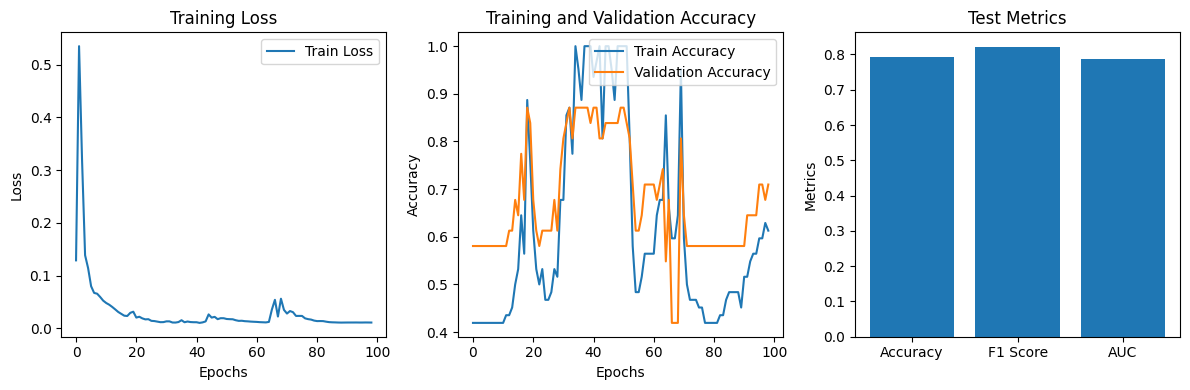

In [43]:
# Plotting

plt.figure(figsize=(12, 4))

  # Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

  # Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_eval_values, label='Train Accuracy')
plt.plot(val_eval_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

  # Assuming 'evaluate' function returns acc, f1, auc
acc, f1, auc = evaluate(best_model, test_loader)

  # Plot F1 Score and AUC
plt.subplot(1, 3, 3)
plt.bar(['Accuracy', 'F1 Score', 'AUC'], [acc, f1, auc])
plt.ylabel('Metrics')
plt.title('Test Metrics')

plt.tight_layout()
plt.show()